In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in ".\animal-faces" (use force=True to force download)


In [2]:
%pip uninstall pil
%pip install --upgrade pillow

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import os

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available: ", device)
print("Is Cuda available?: ", torch.cuda.is_available())  # Should print: True
print(torch.cuda.get_device_name())  # Should print your GPU name

Device available:  cuda
Is Cuda available?:  True
NVIDIA GeForce RTX 3060


In [5]:
base_path = Path(os.getcwd()).resolve()

image_path = []
labels = []

afhq_path = base_path / "animal-faces" / "afhq"

for i in os.listdir(afhq_path):
    label_path = afhq_path / i
    for label in os.listdir(label_path):
        image_path_label_path = label_path / label
        for image in os.listdir(image_path_label_path):
            image_path.append(image_path_label_path / image)
            labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

print(data_df["labels"].unique())
data_df.head()


['cat' 'dog' 'wild']


,image_path,labels
0,E:\Python\PyTorch in 5 projects\animal-faces\a...,cat
1,E:\Python\PyTorch in 5 projects\animal-faces\a...,cat
2,E:\Python\PyTorch in 5 projects\animal-faces\a...,cat
3,E:\Python\PyTorch in 5 projects\animal-faces\a...,cat
4,E:\Python\PyTorch in 5 projects\animal-faces\a...,cat


In [6]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)
            
        return image, label

In [9]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

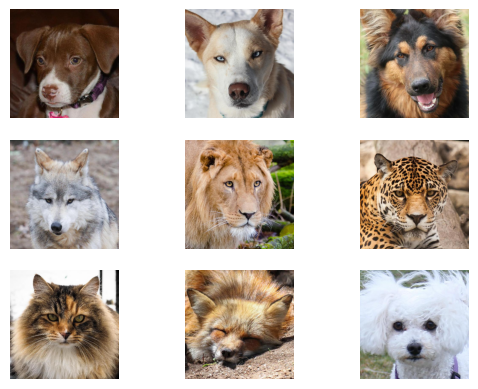

In [10]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row,col].imshow(image)
        axarr[row,col].axis("off")
plt.show()

    

In [11]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [12]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.convl = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2,2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        x = self.convl(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [14]:
model = Net().to(device)

In [15]:
from torchsummary import summary
summary(model, input_size = (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [17]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)    

        labels = labels.long()
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()

        total_acc_train += train_acc
        optimizer.step()
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            labels = labels.long()
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
    
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round((total_acc_train/ train_dataset.__len__()) * 100, 4))
    total_acc_validation_plot.append(round((total_acc_val/ val_dataset.__len__()) * 100, 4))

    print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000, 4)}  Train Accuracy {round((total_acc_train/ train_dataset.__len__()) * 100, 4)}
            Validation Loss {round(total_loss_val/1000, 4)} Validation Accuracy {round((total_acc_val/ val_dataset.__len__()) * 100, 4)}
        ''')


Epoch 1/10, Train Loss: 0.326  Train Accuracy 80.4092
            Validation Loss 0.0425 Validation Accuracy 90.124
        
Epoch 2/10, Train Loss: 0.1291  Train Accuracy 93.5258
            Validation Loss 0.0308 Validation Accuracy 91.9835
        
Epoch 3/10, Train Loss: 0.0845  Train Accuracy 95.6868
            Validation Loss 0.0227 Validation Accuracy 94.5455
        
Epoch 4/10, Train Loss: 0.0549  Train Accuracy 97.405
            Validation Loss 0.0253 Validation Accuracy 93.9669
        
Epoch 5/10, Train Loss: 0.0389  Train Accuracy 98.0427
            Validation Loss 0.0202 Validation Accuracy 95.4959
        
Epoch 6/10, Train Loss: 0.0333  Train Accuracy 98.273
            Validation Loss 0.0212 Validation Accuracy 95.5372
        
Epoch 7/10, Train Loss: 0.0198  Train Accuracy 99.1321
            Validation Loss 0.0204 Validation Accuracy 95.9504
        
Epoch 8/10, Train Loss: 0.015  Train Accuracy 99.3535
            Validation Loss 0.0248 Validation Accuracy 95.454

In [18]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        predictions = model(inputs)

        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

    print(f'Accuracy Score is: {round(total_acc_test/test_dataset.__len__() * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}')

Accuracy Score is: 96.5688 and Loss is 0.0201


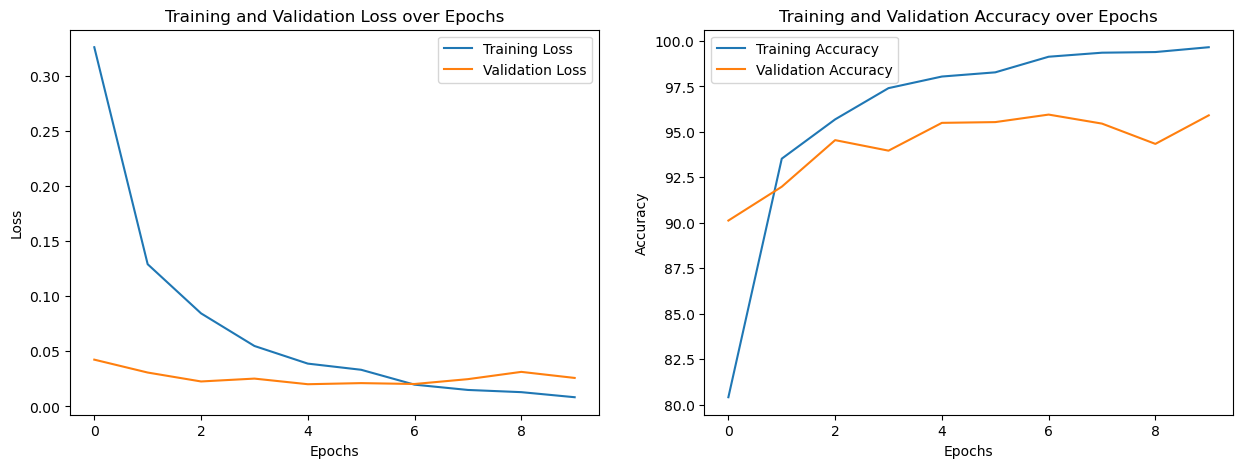

In [19]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

1 - read image  
2 - Transform using transform object  
3 - predict through the model  
4 - inverse transform by label encoder

In [20]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)

    model.eval()

    with torch.no_grad():
        output = model(image.unsqueeze(0))

    output = torch.argmax(output, axis=1).item()
    return label_encoder.inverse_transform([output])

In [21]:
predict_image("AnimalSample.jpg").item()

'dog'